# Customer Churn Prediction Model

## Project Overview
This notebook implements a comprehensive machine learning pipeline to predict customer churn, providing actionable insights for business strategy.

## Table of Contents
1. [Data Loading](#1-data-loading)
2. [Data Cleaning & Preprocessing](#2-data-cleaning--preprocessing)
3. [Exploratory Data Analysis](#3-exploratory-data-analysis)
4. [Feature Engineering](#4-feature-engineering)
5. [Model Training & Evaluation](#5-model-training--evaluation)
6. [Results & Insights](#6-results--insights)

---

## Import Libraries

In [27]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.impute import SimpleImputer
import xgboost as xgb
from imblearn.over_sampling import SMOTE

# Utilities
import warnings
import os
from tqdm import tqdm
import joblib

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



print(" All libraries imported successfully!")

 All libraries imported successfully!


# 1. Data Loading

Load the customer dataset and perform initial inspection.

In [28]:
# Define data file path
# Replace '/content/churn.csv' with the actual path to your file in Colab
# You might need to upload the file to your Colab environment first.
df = pd.read_csv('/churn.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Data Information & Structure

In [29]:
if df is not None:
    # Detailed data information
    print(" Detailed Data Information:")
    print(df.info())

    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"\n Duplicate rows: {duplicates}")

    # Check data types
    print("\n Data Types:")
    for col in df.columns:
        print(f"{col}: {df[col].dtype} ({df[col].nunique()} unique values)")

 Detailed Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilli

# 2. Data Cleaning & Preprocessing

Handle missing values, remove unnecessary columns, and prepare data for analysis.

## 2.1 Missing Values Analysis

In [30]:
if df is not None:
    def analyze_missing_values(df):
        """
        Analyze missing values in the dataset.

        Args:
            df (pd.DataFrame): Input dataframe

        Returns:
            pd.DataFrame: Missing values summary
        """
        missing_data = df.isnull().sum()
        missing_percent = (missing_data / len(df)) * 100

        missing_summary = pd.DataFrame({
            'Missing_Count': missing_data,
            'Missing_Percentage': missing_percent
        })

        missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]
        missing_summary = missing_summary.sort_values('Missing_Count', ascending=False)

        return missing_summary

    # Analyze missing values
    missing_summary = analyze_missing_values(df)

    if not missing_summary.empty:
        print(" Missing Values Found:")
        display(missing_summary)

        # Visualize missing values
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.barplot(x=missing_summary.index, y=missing_summary['Missing_Count'])
        plt.title('Missing Values Count')
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        sns.barplot(x=missing_summary.index, y=missing_summary['Missing_Percentage'])
        plt.title('Missing Values Percentage')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()
    else:
        print(" No missing values found in the dataset!")

 No missing values found in the dataset!


## 2.2 Handle Missing Values

In [31]:
if df is not None:
    def handle_missing_values(df):
        """
        Handle missing values using appropriate strategies.

        Args:
            df (pd.DataFrame): Input dataframe

        Returns:
            pd.DataFrame: Dataframe with handled missing values
        """
        df_clean = df.copy()

        # Strategy for numerical columns: median imputation
        numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numerical_cols:
            if df_clean[col].isnull().sum() > 0:
                median_value = df_clean[col].median()
                df_clean[col].fillna(median_value, inplace=True)
                print(f" Filled {col} missing values with median: {median_value}")

        # Strategy for categorical columns: mode imputation
        categorical_cols = df_clean.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if df_clean[col].isnull().sum() > 0:
                mode_value = df_clean[col].mode()[0]
                df_clean[col].fillna(mode_value, inplace=True)
                print(f" Filled {col} missing values with mode: {mode_value}")

        return df_clean

    # Handle missing values
    df_clean = handle_missing_values(df)

    # Verify no missing values remain
    remaining_missing = df_clean.isnull().sum().sum()
    print(f"\n Missing values after cleaning: {remaining_missing}")

    print(f"\n Dataset shape after cleaning: {df_clean.shape}")


 Missing values after cleaning: 0

 Dataset shape after cleaning: (7043, 21)


## 2.3 Remove Unnecessary Columns

In [32]:
if df is not None:
    def identify_unnecessary_columns(df):
        """
        Identify columns that should be removed for prediction.

        Args:
            df (pd.DataFrame): Input dataframe

        Returns:
            list: List of columns to remove
        """
        # Common patterns for unnecessary columns
        unnecessary_patterns = [
            'id', 'ID', 'customer_id', 'customerID', 'customerId',
            'name', 'Name', 'email', 'phone', 'address'
        ]

        columns_to_remove = []

        for col in df.columns:
            # Check if column name matches unnecessary patterns
            if any(pattern in col for pattern in unnecessary_patterns):
                columns_to_remove.append(col)
            # Check if column has too many unique values (likely an identifier)
            elif df[col].nunique() == len(df) and col.lower() != 'churn':
                columns_to_remove.append(col)

        return columns_to_remove

    # Identify unnecessary columns
    unnecessary_cols = identify_unnecessary_columns(df_clean)

    if unnecessary_cols:
        print(f"🗑️ Identified columns to remove: {unnecessary_cols}")

        # Remove unnecessary columns
        df_clean = df_clean.drop(columns=unnecessary_cols)
        print(f" Removed {len(unnecessary_cols)} unnecessary columns")
    else:
        print(" No unnecessary columns identified")

    print(f"\n Final dataset shape: {df_clean.shape}")
    print(f" Remaining columns: {list(df_clean.columns)}")

🗑️ Identified columns to remove: ['customerID']
 Removed 1 unnecessary columns

 Final dataset shape: (7043, 20)
 Remaining columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


# 3. Exploratory Data Analysis

Comprehensive analysis of the data including distributions, correlations, and churn patterns.

## 3.1 Target Variable Analysis

 Target column identified: Churn

 Churn Distribution:
No Churn (0): 5174 (73.46%)
Churn (1): 1869 (26.54%)


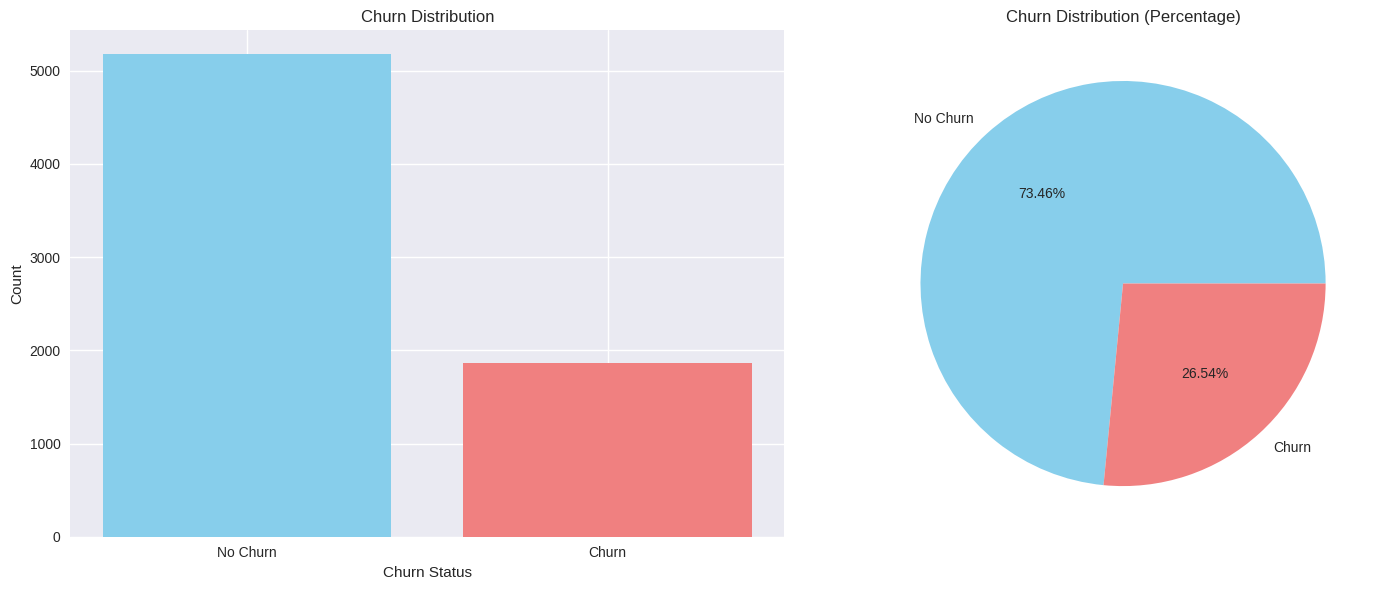

 Class imbalance detected (ratio: 0.36)
Consider using techniques like SMOTE for balancing during model training.


In [33]:
if df is not None:
    # Identify target column
    target_candidates = ['churn', 'Churn', 'CHURN', 'churned', 'Churned']
    target_col = None

    for col in target_candidates:
        if col in df_clean.columns:
            target_col = col
            break

    if target_col:
        print(f" Target column identified: {target_col}")

        # Convert target to binary if needed
        if df_clean[target_col].dtype == 'object':
            # Map common churn representations to binary
            churn_mapping = {
                'Yes': 1, 'No': 0,
                'True': 1, 'False': 0,
                '1': 1, '0': 0,
                True: 1, False: 0
            }
            df_clean[target_col] = df_clean[target_col].map(churn_mapping)

        # Analyze target distribution
        churn_counts = df_clean[target_col].value_counts()
        churn_percentages = df_clean[target_col].value_counts(normalize=True) * 100

        print(f"\n Churn Distribution:")
        print(f"No Churn (0): {churn_counts[0]} ({churn_percentages[0]:.2f}%)")
        print(f"Churn (1): {churn_counts[1]} ({churn_percentages[1]:.2f}%)")

        # Visualize target distribution
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Bar plot
        axes[0].bar(churn_counts.index, churn_counts.values,
                   color=['skyblue', 'lightcoral'])
        axes[0].set_xlabel('Churn Status')
        axes[0].set_ylabel('Count')
        axes[0].set_title('Churn Distribution')
        axes[0].set_xticks([0, 1])
        axes[0].set_xticklabels(['No Churn', 'Churn'])

        # Pie chart
        axes[1].pie(churn_counts.values, labels=['No Churn', 'Churn'],
                   colors=['skyblue', 'lightcoral'], autopct='%1.2f%%')
        axes[1].set_title('Churn Distribution (Percentage)')

        plt.tight_layout()
        plt.show()

        # Check for class imbalance
        imbalance_ratio = churn_counts.min() / churn_counts.max()
        if imbalance_ratio < 0.7:
            print(f" Class imbalance detected (ratio: {imbalance_ratio:.2f})")
            print("Consider using techniques like SMOTE for balancing during model training.")
        else:
            print(" Classes are relatively balanced")
    else:
        print(" Target column not found. Please ensure your dataset has a 'Churn' column.")
        print("Available columns:", list(df_clean.columns))

## 3.2 Numerical Features Analysis

 Numerical features: ['SeniorCitizen', 'tenure', 'MonthlyCharges']


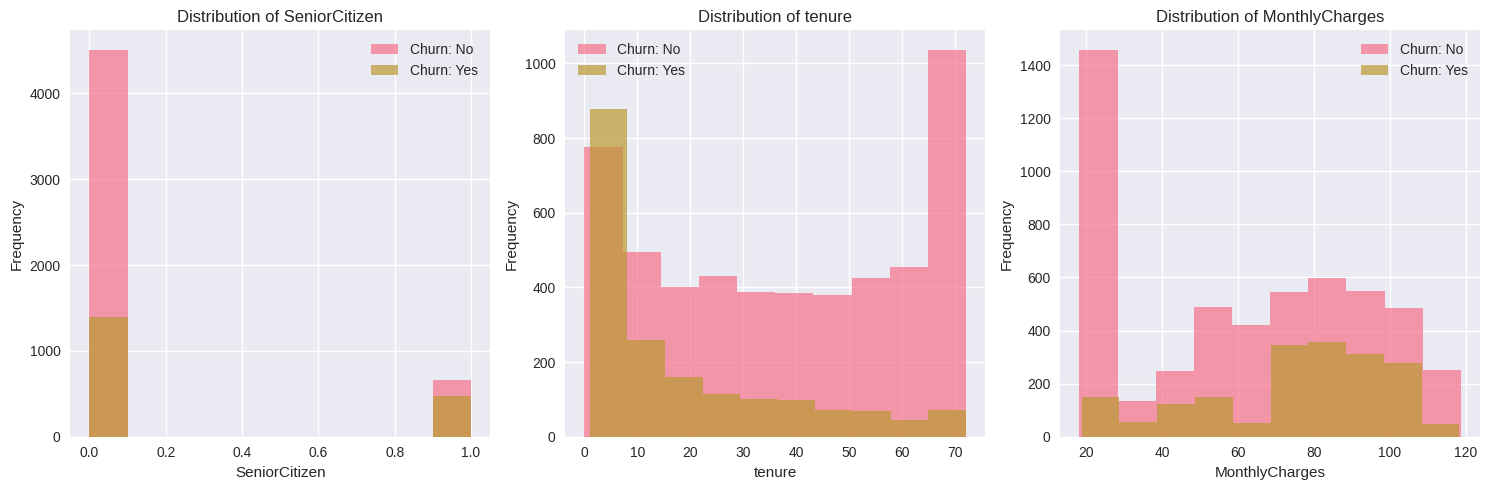


 Statistical Summary by Churn Status:

SeniorCitizen:


,mean,median,std
Churn,,,
0,0.128721,0.0,0.334923
1,0.254682,0.0,0.435799



tenure:


,mean,median,std
Churn,,,
0,37.569965,38.0,24.113777
1,17.979133,10.0,19.531123



MonthlyCharges:


,mean,median,std
Churn,,,
0,61.265124,64.425,31.092648
1,74.441332,79.650,24.666053


In [34]:
if df is not None and target_col:
    # Get numerical columns (excluding target)
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)

    if numerical_cols:
        print(f" Numerical features: {numerical_cols}")

        # Distribution plots
        n_cols = min(3, len(numerical_cols))
        n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        elif len(numerical_cols) == 1:
            axes = axes.reshape(-1, 1)

        for i, col in enumerate(numerical_cols):
            row = i // n_cols
            col_idx = i % n_cols

            if row < n_rows and col_idx < n_cols:
                # Distribution by churn status
                for churn_val in [0, 1]:
                    data = df_clean[df_clean[target_col] == churn_val][col]
                    axes[row, col_idx].hist(data, alpha=0.7,
                                          label=f'Churn: {"Yes" if churn_val else "No"}')

                axes[row, col_idx].set_title(f'Distribution of {col}')
                axes[row, col_idx].set_xlabel(col)
                axes[row, col_idx].set_ylabel('Frequency')
                axes[row, col_idx].legend()

        # Remove empty subplots
        for i in range(len(numerical_cols), n_rows * n_cols):
            row = i // n_cols
            col_idx = i % n_cols
            if row < n_rows and col_idx < n_cols:
                fig.delaxes(axes[row, col_idx])

        plt.tight_layout()
        plt.show()

        # Statistical summary by churn
        print("\n Statistical Summary by Churn Status:")
        for col in numerical_cols:
            print(f"\n{col}:")
            summary = df_clean.groupby(target_col)[col].agg(['mean', 'median', 'std'])
            display(summary)
    else:
        print("No numerical features found (excluding target).")

## 3.3 Categorical Features Analysis

 Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']

 Analysis of gender:
Churn rate by gender:


Churn,0,1
gender,,
Female,73.08,26.92
Male,73.84,26.16


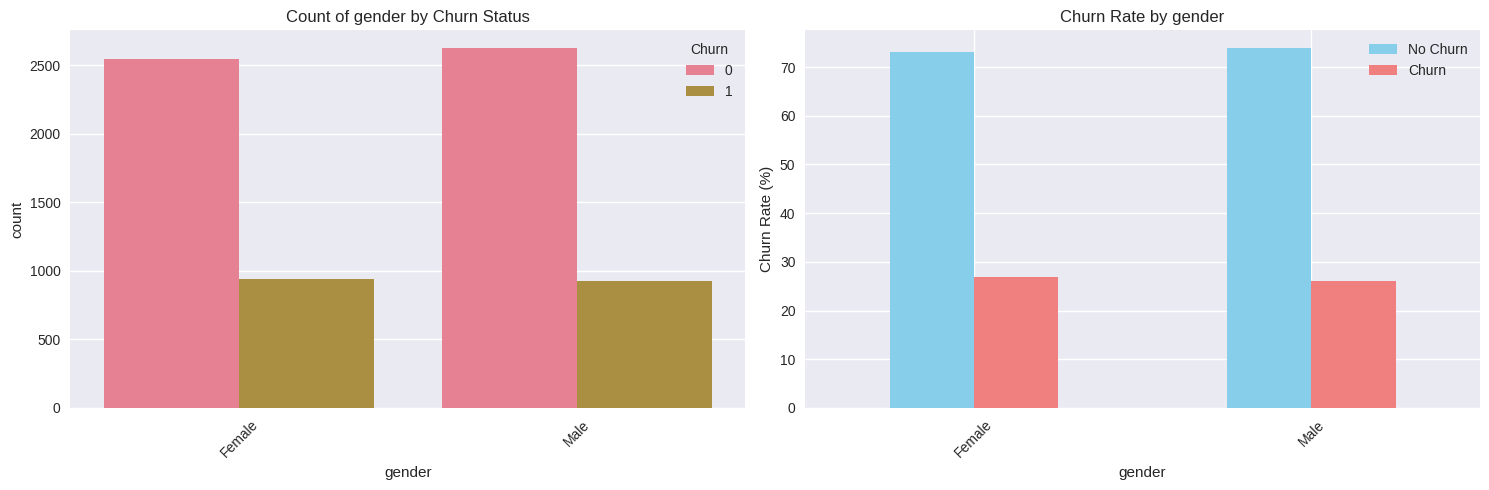


 Analysis of Partner:
Churn rate by Partner:


Churn,0,1
Partner,,
No,67.04,32.96
Yes,80.34,19.66


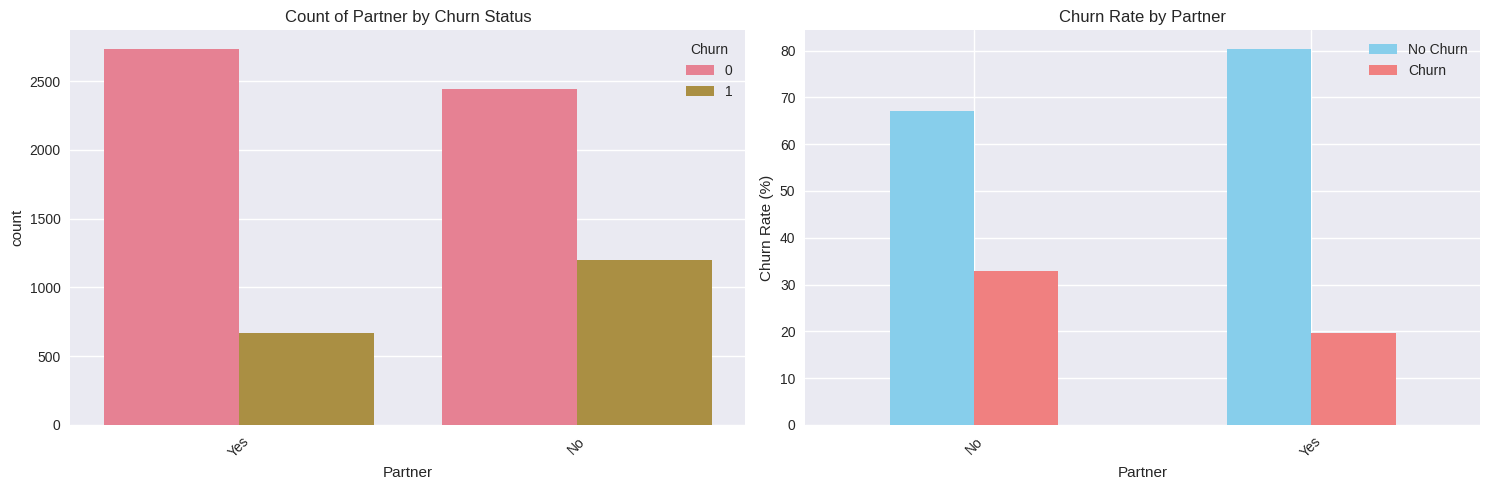


 Analysis of Dependents:
Churn rate by Dependents:


Churn,0,1
Dependents,,
No,68.72,31.28
Yes,84.55,15.45


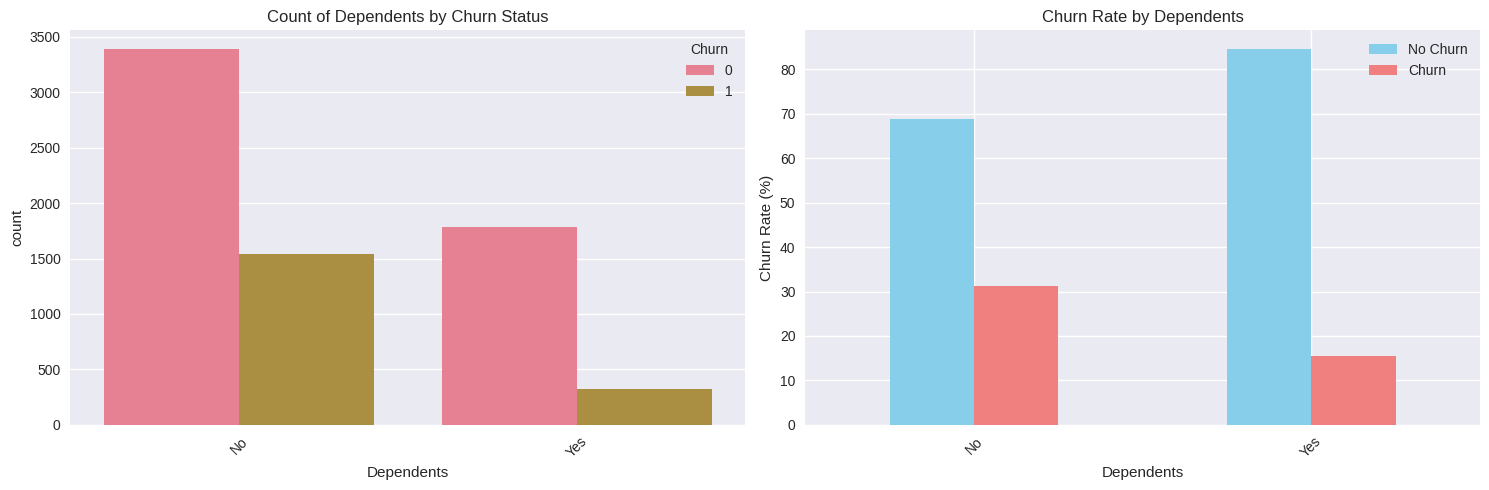


 Analysis of PhoneService:
Churn rate by PhoneService:


Churn,0,1
PhoneService,,
No,75.07,24.93
Yes,73.29,26.71


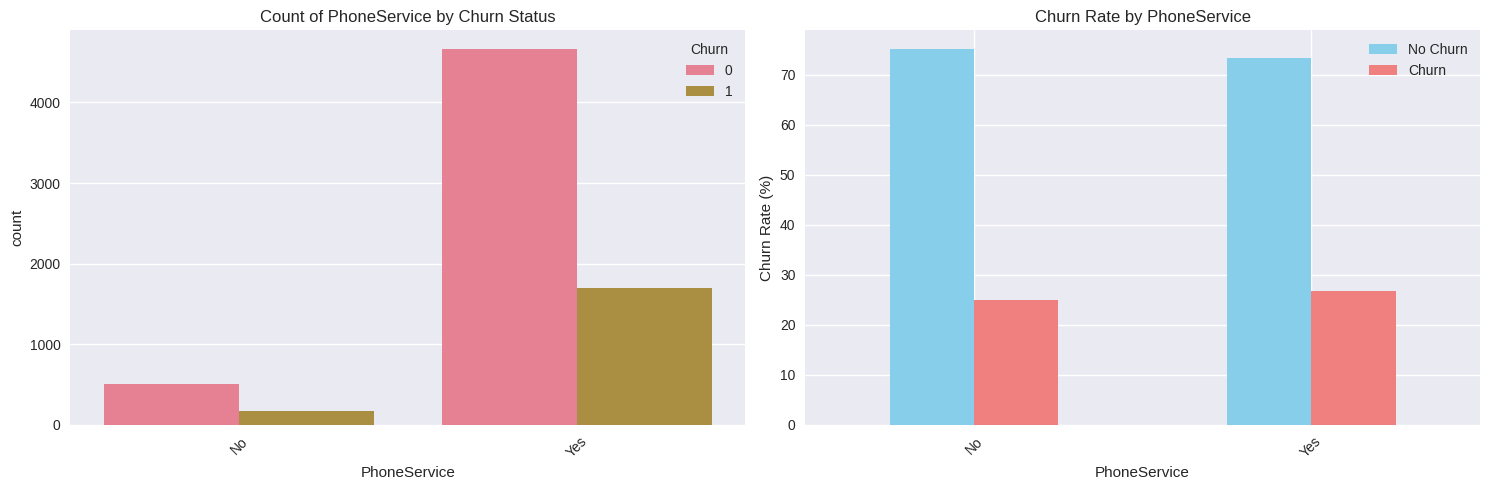


 Analysis of MultipleLines:
Churn rate by MultipleLines:


Churn,0,1
MultipleLines,,
No,74.96,25.04
No phone service,75.07,24.93
Yes,71.39,28.61


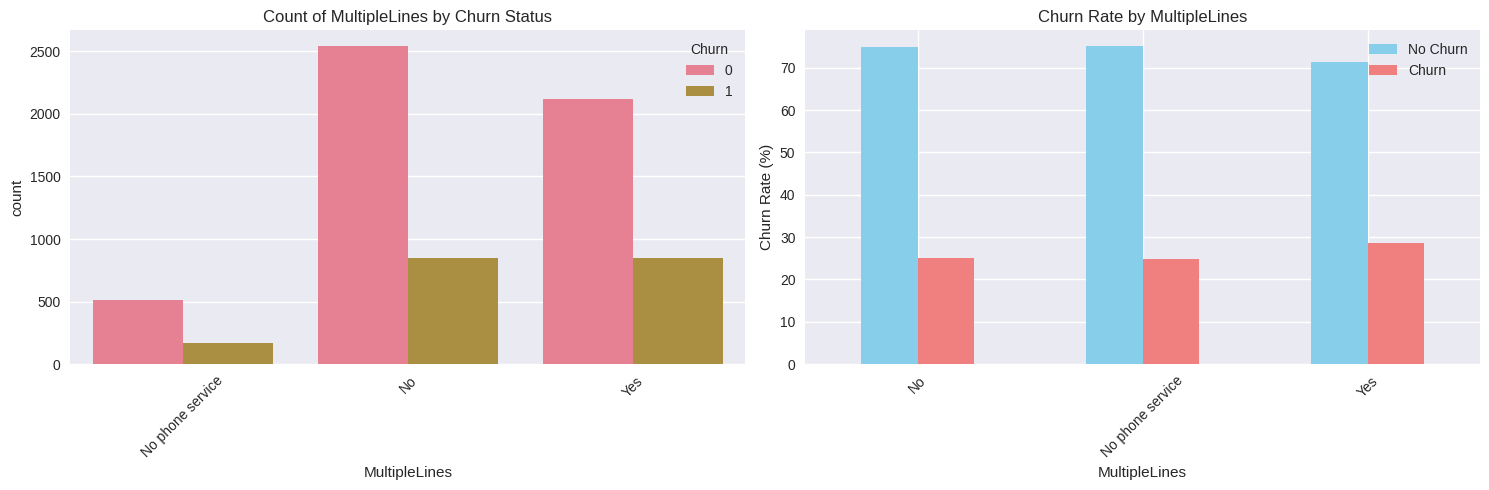


 Analysis of InternetService:
Churn rate by InternetService:


Churn,0,1
InternetService,,
DSL,81.04,18.96
Fiber optic,58.11,41.89
No,92.60,7.40


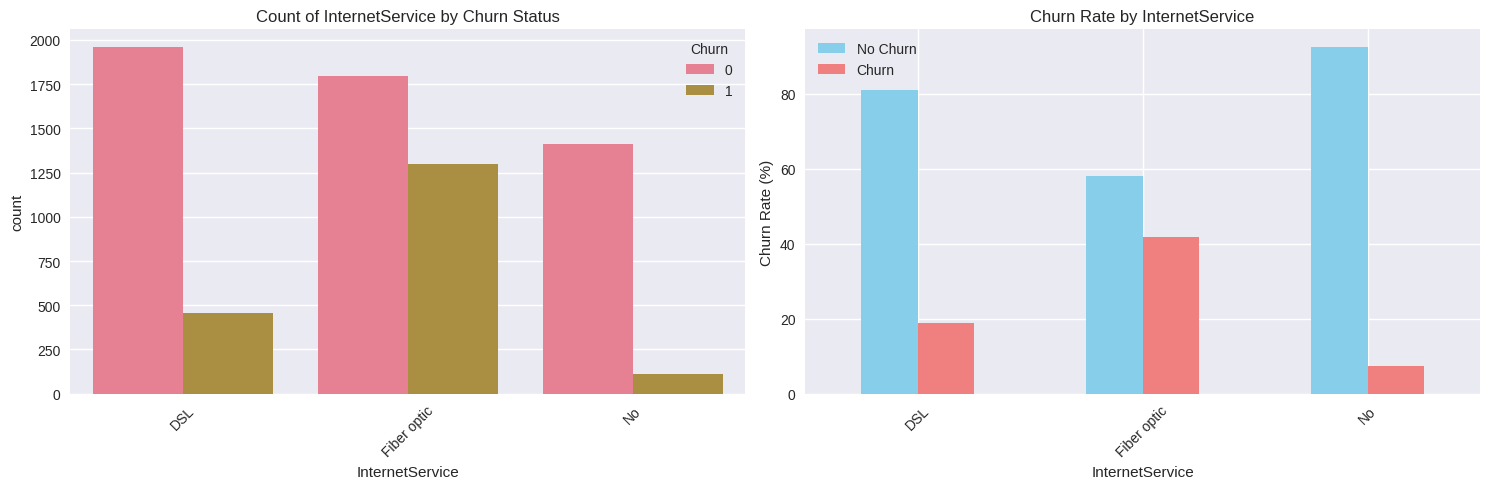


 Analysis of OnlineSecurity:
Churn rate by OnlineSecurity:


Churn,0,1
OnlineSecurity,,
No,58.23,41.77
No internet service,92.60,7.40
Yes,85.39,14.61


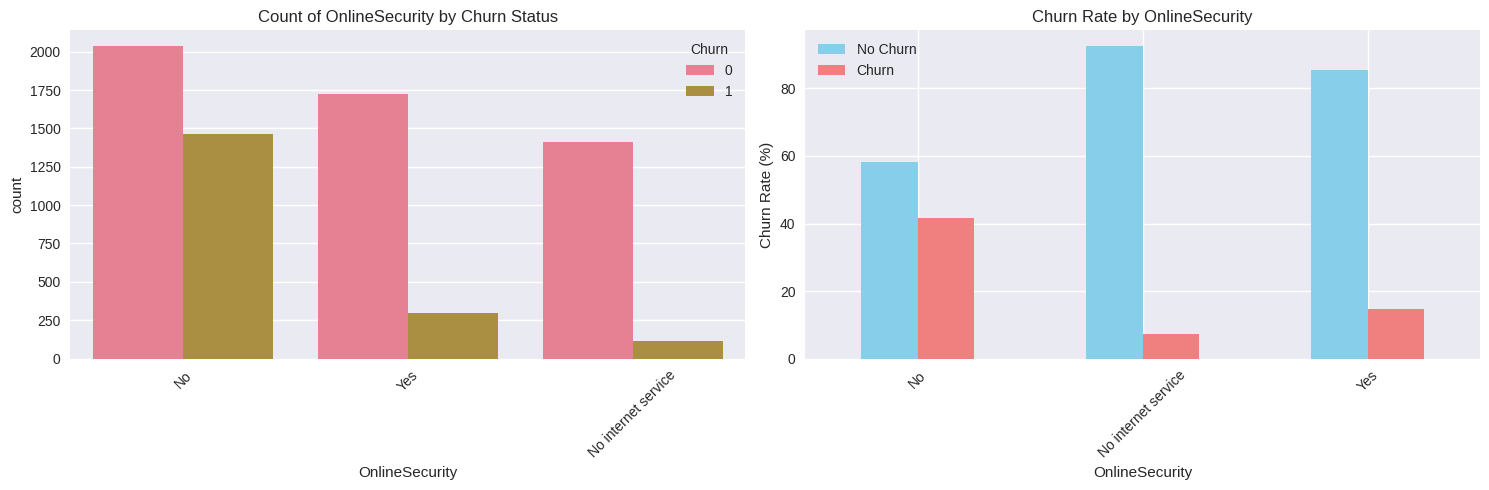


 Analysis of OnlineBackup:
Churn rate by OnlineBackup:


Churn,0,1
OnlineBackup,,
No,60.07,39.93
No internet service,92.60,7.40
Yes,78.47,21.53


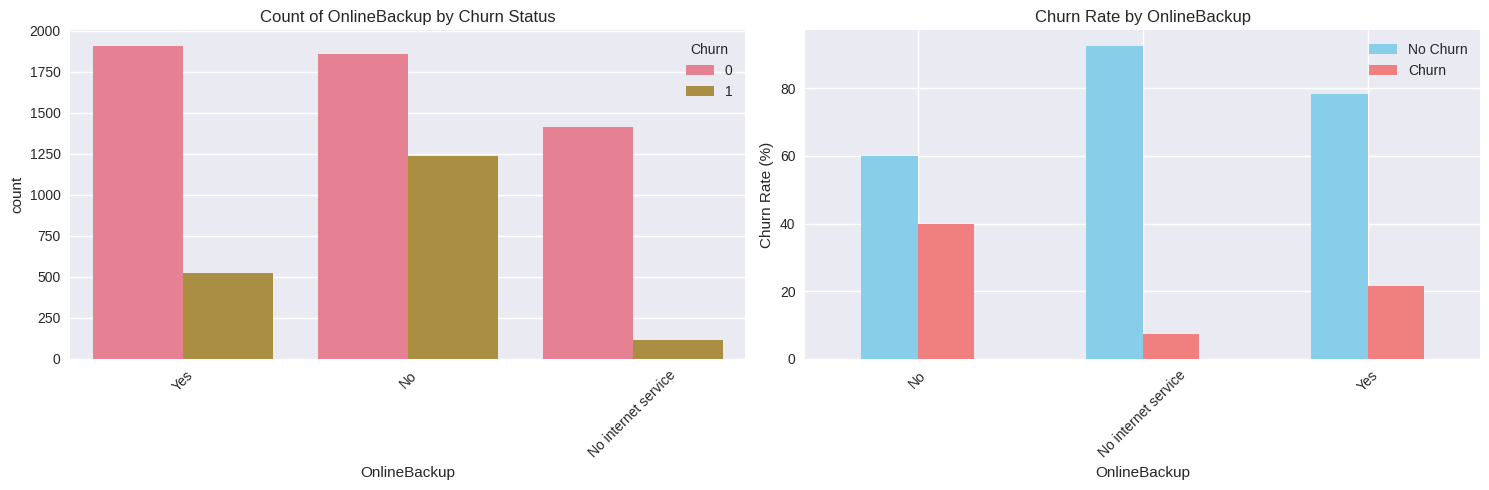


 Analysis of DeviceProtection:
Churn rate by DeviceProtection:


Churn,0,1
DeviceProtection,,
No,60.87,39.13
No internet service,92.60,7.40
Yes,77.50,22.50


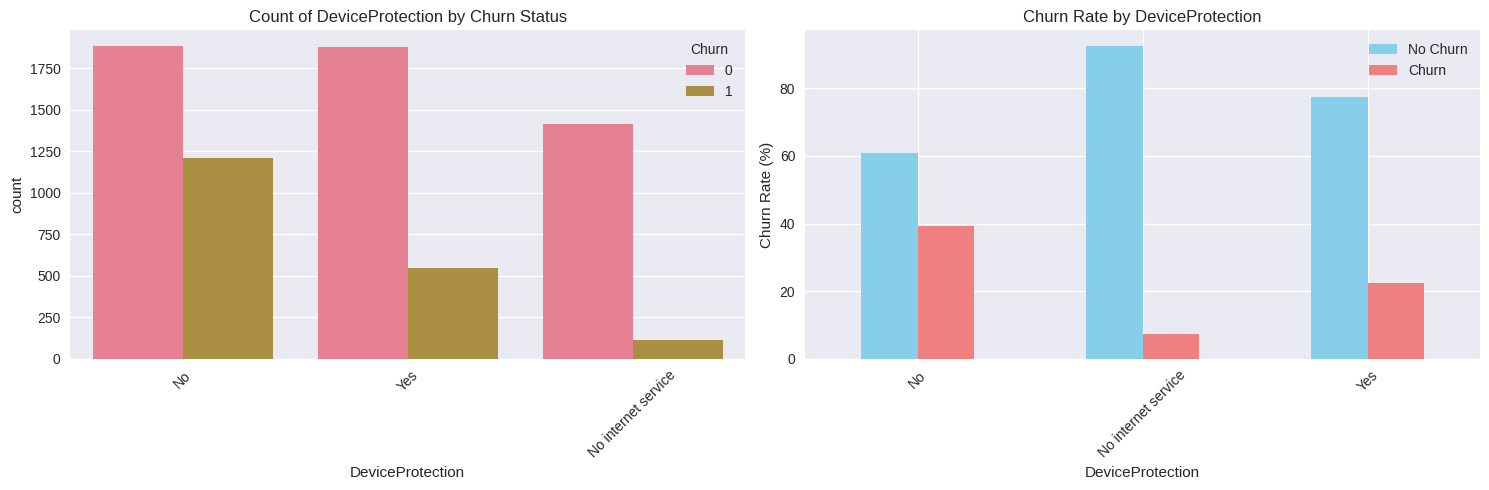


 Analysis of TechSupport:
Churn rate by TechSupport:


Churn,0,1
TechSupport,,
No,58.36,41.64
No internet service,92.60,7.40
Yes,84.83,15.17


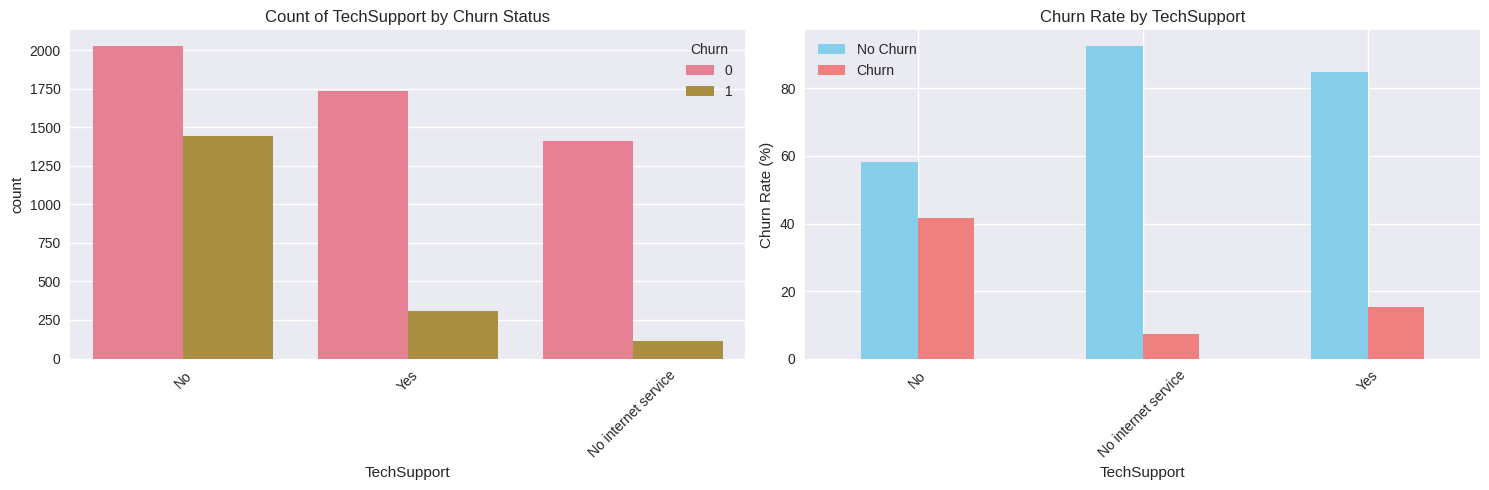


 Analysis of StreamingTV:
Churn rate by StreamingTV:


Churn,0,1
StreamingTV,,
No,66.48,33.52
No internet service,92.60,7.40
Yes,69.93,30.07


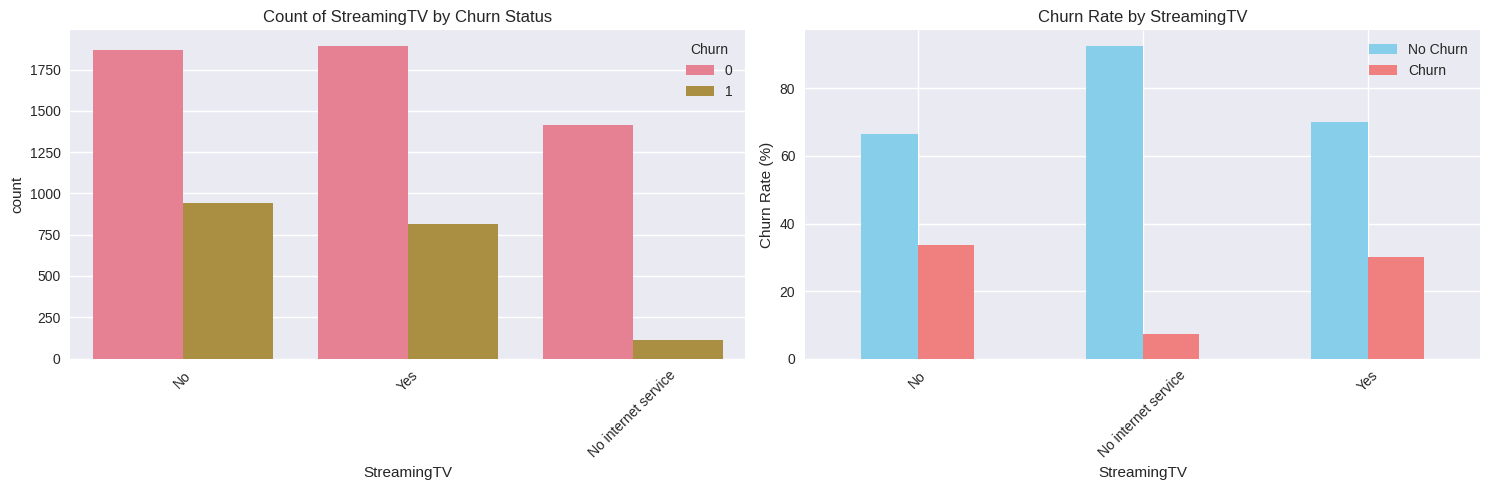


 Analysis of StreamingMovies:
Churn rate by StreamingMovies:


Churn,0,1
StreamingMovies,,
No,66.32,33.68
No internet service,92.60,7.40
Yes,70.06,29.94


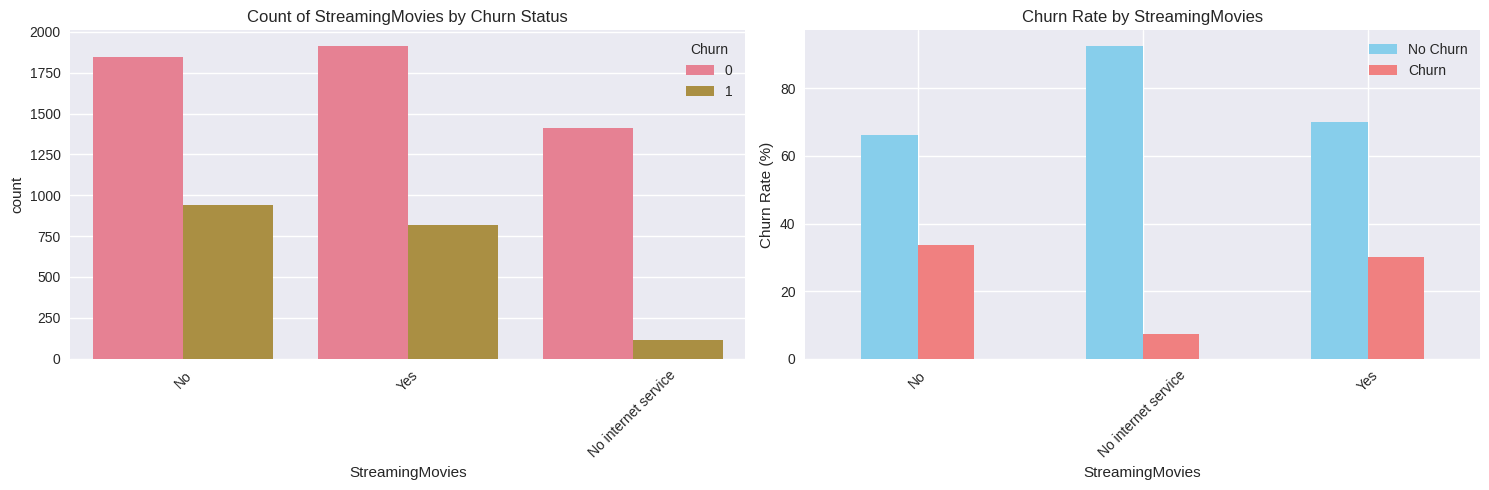


 Analysis of Contract:
Churn rate by Contract:


Churn,0,1
Contract,,
Month-to-month,57.29,42.71
One year,88.73,11.27
Two year,97.17,2.83


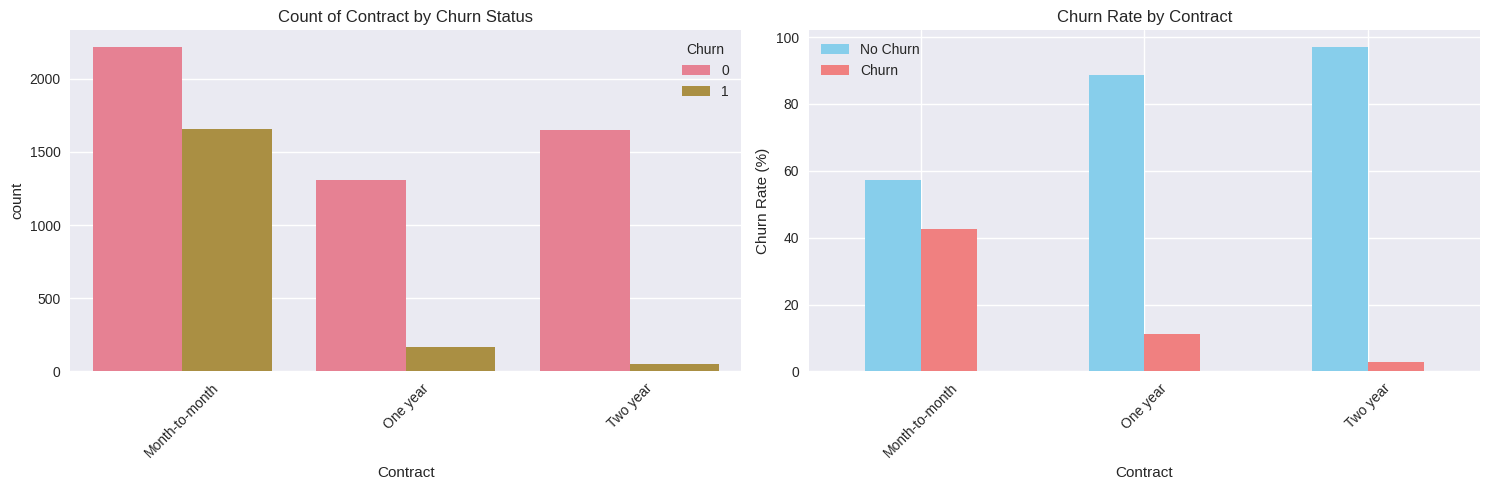


 Analysis of PaperlessBilling:
Churn rate by PaperlessBilling:


Churn,0,1
PaperlessBilling,,
No,83.67,16.33
Yes,66.43,33.57


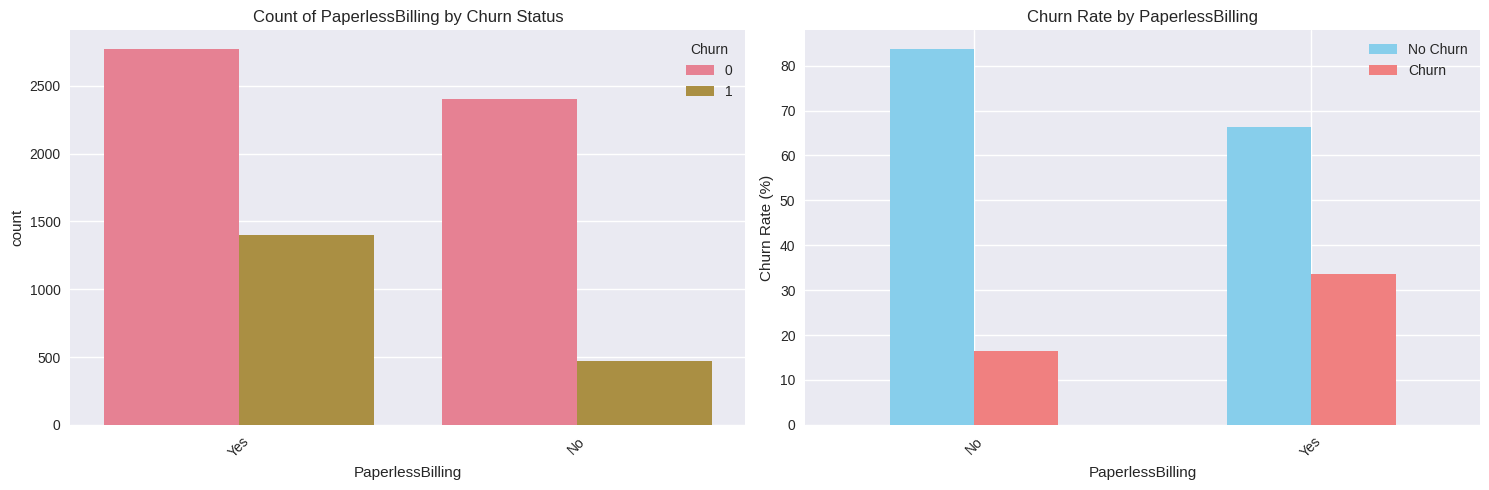


 Analysis of PaymentMethod:
Churn rate by PaymentMethod:


Churn,0,1
PaymentMethod,,
Bank transfer (automatic),83.29,16.71
Credit card (automatic),84.76,15.24
Electronic check,54.71,45.29
Mailed check,80.89,19.11


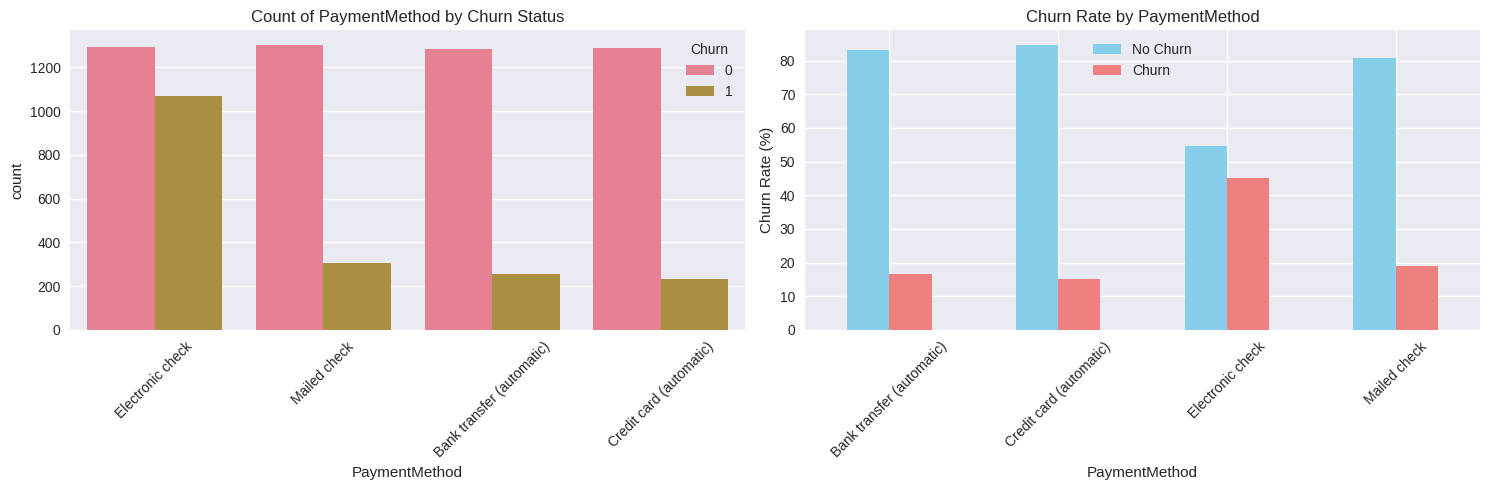


 Analysis of TotalCharges:
Churn rate by TotalCharges:


Churn,0,1
TotalCharges,,
,100.0,0.0
100.2,100.0,0.0
100.25,0.0,100.0
100.35,100.0,0.0
100.4,0.0,100.0
...,...,...
997.75,100.0,0.0
998.1,100.0,0.0
999.45,0.0,100.0


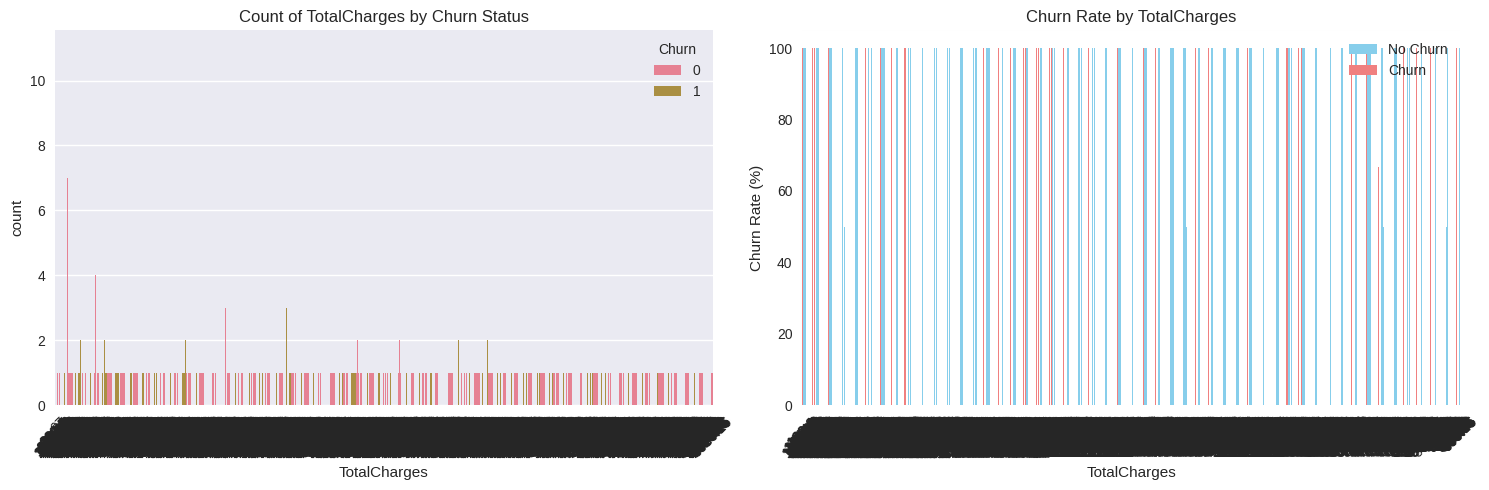

In [35]:
if df is not None and target_col:
    # Get categorical columns
    categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

    if categorical_cols:
        print(f" Categorical features: {categorical_cols}")

        # Analyze each categorical feature
        for col in categorical_cols:
            print(f"\n Analysis of {col}:")

            # Cross-tabulation with churn
            cross_tab = pd.crosstab(df_clean[col], df_clean[target_col], normalize='index') * 100
            print(f"Churn rate by {col}:")
            display(cross_tab.round(2))

            # Visualization
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))

            # Count plot
            sns.countplot(data=df_clean, x=col, hue=target_col, ax=axes[0])
            axes[0].set_title(f'Count of {col} by Churn Status')
            axes[0].tick_params(axis='x', rotation=45)

            # Percentage plot
            cross_tab.plot(kind='bar', ax=axes[1], color=['skyblue', 'lightcoral'])
            axes[1].set_title(f'Churn Rate by {col}')
            axes[1].set_ylabel('Churn Rate (%)')
            axes[1].tick_params(axis='x', rotation=45)
            axes[1].legend(['No Churn', 'Churn'])

            plt.tight_layout()
            plt.show()
    else:
        print("No categorical features found.")

## 3.4 Correlation Analysis

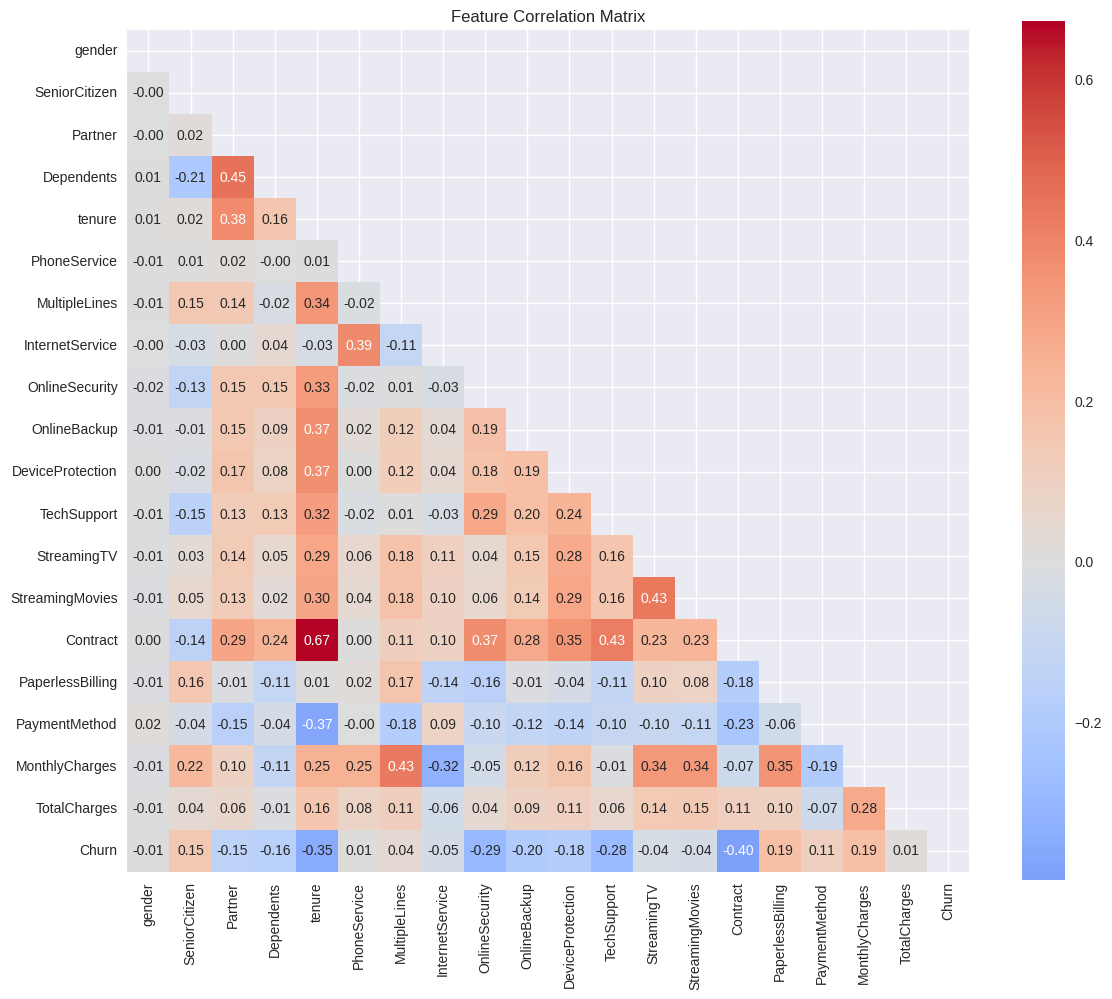


 Features most correlated with Churn:


,Churn
Contract,0.396713
tenure,0.352229
OnlineSecurity,0.289309
TechSupport,0.282492
OnlineBackup,0.195525
MonthlyCharges,0.193356
PaperlessBilling,0.191825
DeviceProtection,0.178134
Dependents,0.164221
SeniorCitizen,0.150889


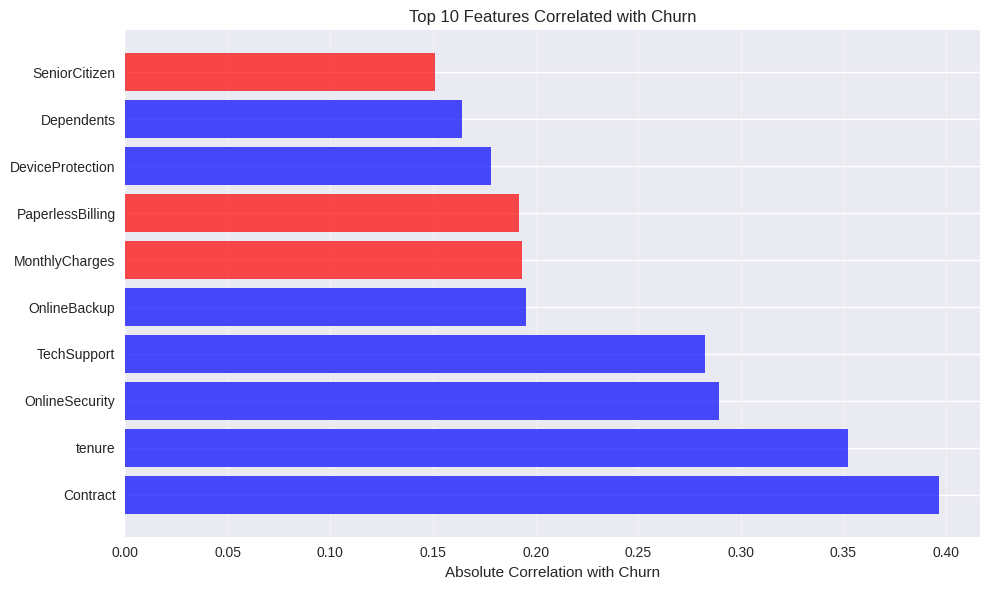

In [36]:
if df is not None and target_col:
    # Create a copy for correlation analysis
    df_corr = df_clean.copy()

    # Encode categorical variables for correlation analysis
    le = LabelEncoder()
    categorical_cols = df_corr.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        df_corr[col] = le.fit_transform(df_corr[col])

    # Calculate correlation matrix
    correlation_matrix = df_corr.corr()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
                center=0, square=True, fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

    # Show correlations with target variable
    target_correlations = correlation_matrix[target_col].abs().sort_values(ascending=False)
    target_correlations = target_correlations[target_correlations.index != target_col]

    print(f"\n Features most correlated with {target_col}:")
    display(target_correlations.head(10))

    # Plot top correlations with target
    plt.figure(figsize=(10, 6))
    top_correlations = target_correlations.head(10)
    colors = ['red' if corr > 0 else 'blue' for corr in correlation_matrix[target_col][top_correlations.index]]
    plt.barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)
    plt.yticks(range(len(top_correlations)), top_correlations.index)
    plt.xlabel('Absolute Correlation with Churn')
    plt.title('Top 10 Features Correlated with Churn')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 4. Feature Engineering

Prepare features for machine learning by encoding categorical variables and scaling numerical features.

## 4.1 Categorical Feature Encoding

In [37]:
if df is not None and target_col:
    def encode_categorical_features(df, target_col):
        """
        Encode categorical features using appropriate methods.

        Args:
            df (pd.DataFrame): Input dataframe
            target_col (str): Target column name

        Returns:
            pd.DataFrame: Dataframe with encoded features
        """
        df_encoded = df.copy()
        categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()

        if not categorical_cols:
            print(" No categorical columns to encode")
            return df_encoded

        print(f" Encoding categorical features: {categorical_cols}")

        for col in categorical_cols:
            unique_values = df_encoded[col].nunique()
            print(f"  {col}: {unique_values} unique values")

            if unique_values == 2:
                # Binary encoding for binary categorical variables
                le = LabelEncoder()
                df_encoded[col] = le.fit_transform(df_encoded[col])
                print(f"     Applied Label Encoding")
            elif unique_values <= 5:
                # One-hot encoding for low cardinality categorical variables
                dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
                df_encoded = pd.concat([df_encoded, dummies], axis=1)
                df_encoded.drop(col, axis=1, inplace=True)
                print(f"     Applied One-Hot Encoding ({len(dummies.columns)} new columns)")
            else:
                # Label encoding for high cardinality categorical variables
                le = LabelEncoder()
                df_encoded[col] = le.fit_transform(df_encoded[col])
                print(f"     Applied Label Encoding (high cardinality)")

        return df_encoded

    # Encode categorical features
    df_encoded = encode_categorical_features(df_clean, target_col)

    print(f"\n Dataset shape after encoding: {df_encoded.shape}")
    print(f" Features after encoding: {len(df_encoded.columns) - 1} (excluding target)")

    # Show data types after encoding
    print("\n Data types after encoding:")
    for col in df_encoded.columns:
        print(f"  {col}: {df_encoded[col].dtype}")

 Encoding categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']
  gender: 2 unique values
     Applied Label Encoding
  Partner: 2 unique values
     Applied Label Encoding
  Dependents: 2 unique values
     Applied Label Encoding
  PhoneService: 2 unique values
     Applied Label Encoding
  MultipleLines: 3 unique values
     Applied One-Hot Encoding (2 new columns)
  InternetService: 3 unique values
     Applied One-Hot Encoding (2 new columns)
  OnlineSecurity: 3 unique values
     Applied One-Hot Encoding (2 new columns)
  OnlineBackup: 3 unique values
     Applied One-Hot Encoding (2 new columns)
  DeviceProtection: 3 unique values
     Applied One-Hot Encoding (2 new columns)
  TechSupport: 3 unique values
     Applied One-Hot Encoding (2 new columns)
  Stream

## 4.2 Feature Scaling

In [38]:
if df is not None and target_col:
    def prepare_features_for_scaling(df, target_col):
        """
        Prepare features and target for scaling.

        Args:
            df (pd.DataFrame): Input dataframe
            target_col (str): Target column name

        Returns:
            tuple: (X, y) features and target
        """
        # Separate features and target
        X = df.drop(target_col, axis=1)
        y = df[target_col]

        return X, y

    # Prepare features and target
    X, y = prepare_features_for_scaling(df_encoded, target_col)

    print(f" Features shape: {X.shape}")
    print(f" Target shape: {y.shape}")
    print(f" Feature names: {list(X.columns)}")

    # Initialize scaler
    scaler = StandardScaler()

    # Note: We'll apply scaling after train-test split to prevent data leakage
    print("\n StandardScaler initialized (will be applied after train-test split)")

    # Show feature statistics before scaling
    print("\n Feature statistics before scaling:")
    display(X.describe())

 Features shape: (7043, 30)
 Target shape: (7043,)
 Feature names: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

 StandardScaler initialized (will be applied after train-test split)

 Feature statistics before scaling:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,32.371149,0.903166,0.592219,64.761692,3257.794122
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.491457,30.090047,1888.693496
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.500000,1609.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,3249.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.850000,4901.500000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,6530.000000


# 5. Model Training & Evaluation

Split data, train models, and evaluate performance.

## 5.1 Data Splitting

In [39]:
if df is not None and target_col:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    print(f" Data split completed:")
    print(f"  Training set: {X_train.shape[0]} samples")
    print(f"  Test set: {X_test.shape[0]} samples")
    print(f"  Features: {X_train.shape[1]}")

    # Check class distribution in splits
    train_churn_dist = y_train.value_counts(normalize=True) * 100
    test_churn_dist = y_test.value_counts(normalize=True) * 100

    print(f"\n Class distribution:")
    print(f"Training set - No Churn: {train_churn_dist[0]:.2f}%, Churn: {train_churn_dist[1]:.2f}%")
    print(f"Test set - No Churn: {test_churn_dist[0]:.2f}%, Churn: {test_churn_dist[1]:.2f}%")

    # Apply scaling
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrames for easier handling
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

    print(f"\n Feature scaling applied")
    print(f"📈 Scaled features statistics:")
    display(X_train_scaled.describe())

 Data split completed:
  Training set: 5634 samples
  Test set: 1409 samples
  Features: 30

 Class distribution:
Training set - No Churn: 73.46%, Churn: 26.54%
Test set - No Churn: 73.46%, Churn: 26.54%

 Feature scaling applied
📈 Scaled features statistics:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03,...,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03,5.634000e+03
mean,1.135052e-16,7.440898e-17,-7.031018e-17,2.900689e-17,-1.008935e-17,-2.679985e-18,3.941154e-17,-2.402527e-16,-1.018394e-16,2.679985e-18,...,-2.017871e-17,-7.724661e-17,8.828185e-18,-7.724661e-17,5.927495e-17,-4.540209e-17,4.760914e-17,-4.287975e-17,-3.279040e-17,-2.017871e-17
std,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,...,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00,1.000089e+00
min,-1.005696e+00,-4.417730e-01,-9.692341e-01,-6.515565e-01,-1.322329e+00,-3.013090e+00,-1.202653e+00,-1.544028e+00,-1.738638e+00,-3.318852e-01,...,-6.432742e-01,-5.240808e-01,-7.986180e-01,-5.240808e-01,-8.013032e-01,-5.127821e-01,-5.638215e-01,-5.238056e-01,-7.107811e-01,-5.438457e-01
25%,-1.005696e+00,-4.417730e-01,-9.692341e-01,-6.515565e-01,-9.559779e-01,3.318852e-01,-1.202653e+00,-9.711977e-01,-8.842582e-01,-3.318852e-01,...,-6.432742e-01,-5.240808e-01,-7.986180e-01,-5.240808e-01,-8.013032e-01,-5.127821e-01,-5.638215e-01,-5.238056e-01,-7.107811e-01,-5.438457e-01
50%,9.943362e-01,-4.417730e-01,-9.692341e-01,-6.515565e-01,-1.418632e-01,3.318852e-01,8.314950e-01,1.848336e-01,1.863241e-03,-3.318852e-01,...,-6.432742e-01,-5.240808e-01,-7.986180e-01,-5.240808e-01,-8.013032e-01,-5.127821e-01,-5.638215e-01,-5.238056e-01,-7.107811e-01,-5.438457e-01
75%,9.943362e-01,-4.417730e-01,1.031742e+00,1.534786e+00,9.164859e-01,3.318852e-01,8.314950e-01,8.319124e-01,8.735687e-01,-3.318852e-01,...,1.554547e+00,-5.240808e-01,1.252163e+00,-5.240808e-01,1.247967e+00,-5.127821e-01,-5.638215e-01,-5.238056e-01,1.406903e+00,-5.438457e-01
max,9.943362e-01,2.263606e+00,1.031742e+00,1.534786e+00,1.608483e+00,3.318852e-01,8.314950e-01,1.785939e+00,1.715913e+00,3.013090e+00,...,1.554547e+00,1.908103e+00,1.252163e+00,1.908103e+00,1.247967e+00,1.950146e+00,1.773611e+00,1.909105e+00,1.406903e+00,1.838757e+00


## 5.2 Handle Class Imbalance (Optional)

In [40]:
if df is not None and target_col:
    # Check if we need to handle class imbalance
    class_counts = y_train.value_counts()
    imbalance_ratio = class_counts.min() / class_counts.max()

    if imbalance_ratio < 0.7:
        print(f" Applying SMOTE to handle class imbalance (ratio: {imbalance_ratio:.2f})")

        # Apply SMOTE
        smote = SMOTE(random_state=RANDOM_STATE)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

        # Convert back to DataFrame
        X_train_balanced = pd.DataFrame(X_train_balanced, columns=X.columns)

        print(f" SMOTE applied:")
        print(f"  Original training size: {len(X_train_scaled)}")
        print(f"  Balanced training size: {len(X_train_balanced)}")

        # Show new class distribution
        balanced_dist = pd.Series(y_train_balanced).value_counts(normalize=True) * 100
        print(f"  New distribution - No Churn: {balanced_dist[0]:.2f}%, Churn: {balanced_dist[1]:.2f}%")

        # Use balanced data for training
        X_train_final = X_train_balanced
        y_train_final = y_train_balanced
    else:
        print(f" Classes are reasonably balanced (ratio: {imbalance_ratio:.2f})")
        X_train_final = X_train_scaled
        y_train_final = y_train

    print(f"\n Final training data shape: {X_train_final.shape}")

 Applying SMOTE to handle class imbalance (ratio: 0.36)
 SMOTE applied:
  Original training size: 5634
  Balanced training size: 8278
  New distribution - No Churn: 50.00%, Churn: 50.00%

 Final training data shape: (8278, 30)


## 5.3 Model Selection and Training

In [41]:
if df is not None and target_col:
    # Define models to compare
    models = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
        'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')
    }

    # Train and evaluate models
    model_results = {}
    trained_models = {}

    print(" Training models...\n")

    for name, model in models.items():
        print(f"Training {name}...")

        # Train the model
        model.fit(X_train_final, y_train_final)

        # Make predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        # Store results
        model_results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        trained_models[name] = model

        print(f"   {name} trained - F1: {f1:.4f}, AUC: {auc:.4f}")

    # Create results summary
    results_df = pd.DataFrame({
        'Model': list(model_results.keys()),
        'Accuracy': [results['accuracy'] for results in model_results.values()],
        'Precision': [results['precision'] for results in model_results.values()],
        'Recall': [results['recall'] for results in model_results.values()],
        'F1-Score': [results['f1_score'] for results in model_results.values()],
        'AUC': [results['auc'] for results in model_results.values()]
    })

    # Sort by F1-score
    results_df = results_df.sort_values('F1-Score', ascending=False)

    print("\n Model Comparison Results:")
    display(results_df.round(4))

    # Select best model
    best_model_name = results_df.iloc[0]['Model']
    best_model = trained_models[best_model_name]

    print(f"\n  Best performing model: {best_model_name}")
    print(f"F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")

 Training models...

Training Logistic Regression...
   Logistic Regression trained - F1: 0.6118, AUC: 0.8375
Training Random Forest...
   Random Forest trained - F1: 0.5809, AUC: 0.8191
Training Gradient Boosting...
   Gradient Boosting trained - F1: 0.6125, AUC: 0.8411
Training XGBoost...
   XGBoost trained - F1: 0.5741, AUC: 0.8134

 Model Comparison Results:


,Model,Accuracy,Precision,Recall,F1-Score,AUC
2,Gradient Boosting,0.7665,0.5474,0.6952,0.6125,0.8411
0,Logistic Regression,0.7388,0.5052,0.7754,0.6118,0.8375
1,Random Forest,0.7757,0.5763,0.5856,0.5809,0.8191
3,XGBoost,0.7715,0.5681,0.5802,0.5741,0.8134



  Best performing model: Gradient Boosting
F1-Score: 0.6125


## 5.4 Hyperparameter Tuning for Best Model

In [42]:
if df is not None and target_col:
    # Define parameter grids for different models
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.2],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.2],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0]
        },
        'Logistic Regression': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    }

    if best_model_name in param_grids:
        print(f" Performing hyperparameter tuning for {best_model_name}...")

        # Get the base model
        if best_model_name == 'Random Forest':
            base_model = RandomForestClassifier(random_state=RANDOM_STATE)
        elif best_model_name == 'Gradient Boosting':
            base_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
        elif best_model_name == 'XGBoost':
            base_model = xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')
        else:
            base_model = LogisticRegression(random_state=RANDOM_STATE)

        # Perform grid search
        grid_search = GridSearchCV(
            base_model,
            param_grids[best_model_name],
            cv=5,
            scoring='f1',
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train_final, y_train_final)

        # Get best model
        best_tuned_model = grid_search.best_estimator_

        print(f"\n Hyperparameter tuning completed")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV F1-score: {grid_search.best_score_:.4f}")

        # Evaluate tuned model on test set
        y_pred_tuned = best_tuned_model.predict(X_test_scaled)
        y_pred_proba_tuned = best_tuned_model.predict_proba(X_test_scaled)[:, 1]

        tuned_f1 = f1_score(y_test, y_pred_tuned)
        tuned_auc = roc_auc_score(y_test, y_pred_proba_tuned)

        print(f"\n Tuned model performance on test set:")
        print(f"F1-Score: {tuned_f1:.4f} (vs {model_results[best_model_name]['f1_score']:.4f} before tuning)")
        print(f"AUC: {tuned_auc:.4f} (vs {model_results[best_model_name]['auc']:.4f} before tuning)")

        # Use tuned model as final model if it's better
        if tuned_f1 > model_results[best_model_name]['f1_score']:
            final_model = best_tuned_model
            final_predictions = y_pred_tuned
            final_probabilities = y_pred_proba_tuned
            print(" Using tuned model as final model")
        else:
            final_model = best_model
            final_predictions = model_results[best_model_name]['predictions']
            final_probabilities = model_results[best_model_name]['probabilities']
            print(" Original model performs better, using original model")
    else:
        final_model = best_model
        final_predictions = model_results[best_model_name]['predictions']
        final_probabilities = model_results[best_model_name]['probabilities']
        print(f" No hyperparameter grid defined for {best_model_name}, using original model")

 Performing hyperparameter tuning for Gradient Boosting...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

 Hyperparameter tuning completed
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV F1-score: 0.8339

 Tuned model performance on test set:
F1-Score: 0.6152 (vs 0.6125 before tuning)
AUC: 0.8410 (vs 0.8411 before tuning)
 Using tuned model as final model


# 6. Results & Insights

Comprehensive evaluation of the final model and business insights.

## 6.1 Detailed Performance Report

In [43]:
if df is not None and target_col:
    # Calculate comprehensive metrics
    final_accuracy = accuracy_score(y_test, final_predictions)
    final_precision = precision_score(y_test, final_predictions)
    final_recall = recall_score(y_test, final_predictions)
    final_f1 = f1_score(y_test, final_predictions)
    final_auc = roc_auc_score(y_test, final_probabilities)

    # Create performance report
    print(" FINAL MODEL PERFORMANCE REPORT")
    print("=" * 50)
    print(f"Model: {best_model_name}")
    print(f"Dataset: {len(y_test)} test samples")
    print("\n Classification Metrics:")
    print(f"  • Accuracy:  {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
    print(f"  • Precision: {final_precision:.4f} ({final_precision*100:.2f}%)")
    print(f"  • Recall:    {final_recall:.4f} ({final_recall*100:.2f}%)")
    print(f"  • F1-Score:  {final_f1:.4f} ({final_f1*100:.2f}%)")
    print(f"  • AUC-ROC:   {final_auc:.4f} ({final_auc*100:.2f}%)")

    # Interpretation guide
    print("\n Metric Interpretation:")
    print(f"  • Accuracy: {final_accuracy*100:.1f}% of predictions are correct")
    print(f"  • Precision: {final_precision*100:.1f}% of predicted churners actually churned")
    print(f"  • Recall: {final_recall*100:.1f}% of actual churners were correctly identified")
    print(f"  • F1-Score: Balanced measure of precision and recall")
    print(f"  • AUC-ROC: Model's ability to distinguish between classes")

    # Classification report
    print("\n Detailed Classification Report:")
    print(classification_report(y_test, final_predictions, target_names=['No Churn', 'Churn']))

 FINAL MODEL PERFORMANCE REPORT
Model: Gradient Boosting
Dataset: 1409 test samples

 Classification Metrics:
  • Accuracy:  0.7700 (77.00%)
  • Precision: 0.5534 (55.34%)
  • Recall:    0.6925 (69.25%)
  • F1-Score:  0.6152 (61.52%)
  • AUC-ROC:   0.8410 (84.10%)

 Metric Interpretation:
  • Accuracy: 77.0% of predictions are correct
  • Precision: 55.3% of predicted churners actually churned
  • Recall: 69.3% of actual churners were correctly identified
  • F1-Score: Balanced measure of precision and recall
  • AUC-ROC: Model's ability to distinguish between classes

 Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.88      0.80      0.84      1035
       Churn       0.55      0.69      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409



## 6.2 Confusion Matrix

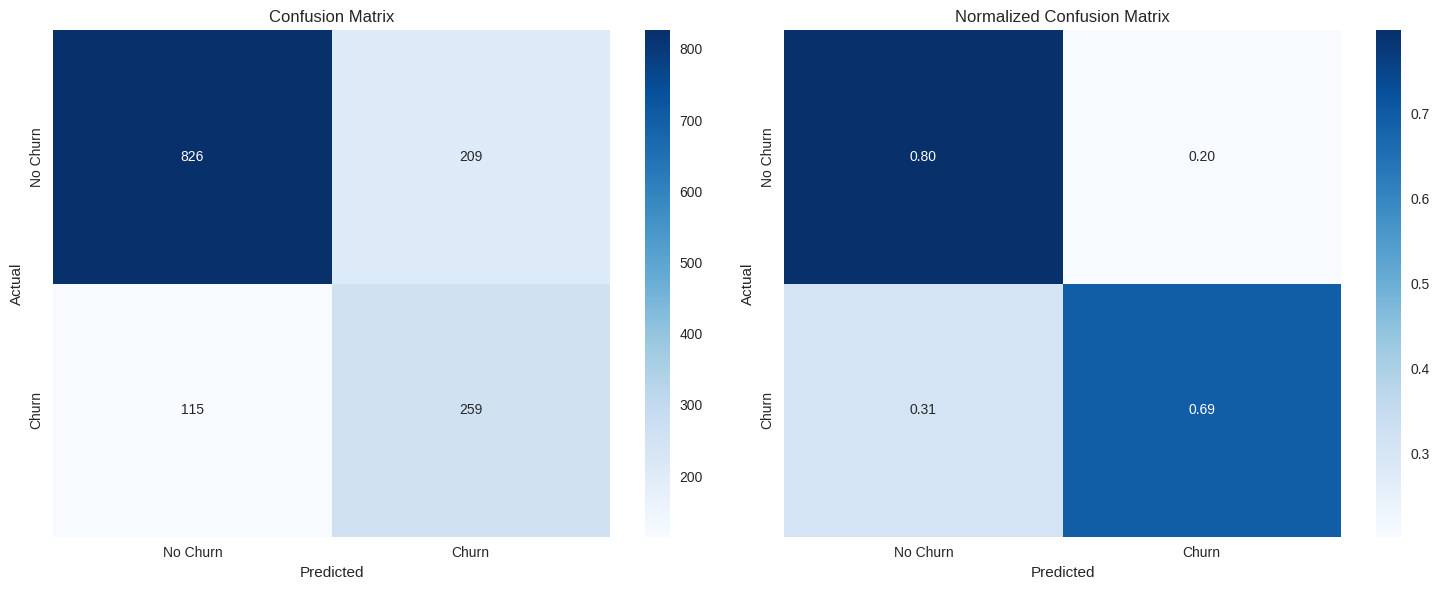

🔍 CONFUSION MATRIX ANALYSIS
True Negatives (TN):   826 - Correctly predicted no churn
False Positives (FP):  209 - Incorrectly predicted churn
False Negatives (FN):  115 - Missed churn cases
True Positives (TP):   259 - Correctly predicted churn

💼 BUSINESS IMPACT:
  • Successfully retained customers: 826 (avoided churn)
  • Unnecessary retention efforts: 209 (false alarms)
  • Missed churn opportunities: 115 (lost customers)
  • Successful churn predictions: 259 (intervention opportunities)


In [44]:
if df is not None and target_col:
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, final_predictions)

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'],
                ax=axes[1])
    axes[1].set_title('Normalized Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Detailed confusion matrix analysis
    tn, fp, fn, tp = cm.ravel()

    print("🔍 CONFUSION MATRIX ANALYSIS")
    print("=" * 40)
    print(f"True Negatives (TN):  {tn:4d} - Correctly predicted no churn")
    print(f"False Positives (FP): {fp:4d} - Incorrectly predicted churn")
    print(f"False Negatives (FN): {fn:4d} - Missed churn cases")
    print(f"True Positives (TP):  {tp:4d} - Correctly predicted churn")

    # Business impact analysis
    print("\n💼 BUSINESS IMPACT:")
    print(f"  • Successfully retained customers: {tn} (avoided churn)")
    print(f"  • Unnecessary retention efforts: {fp} (false alarms)")
    print(f"  • Missed churn opportunities: {fn} (lost customers)")
    print(f"  • Successful churn predictions: {tp} (intervention opportunities)")

## 6.3 ROC Curve

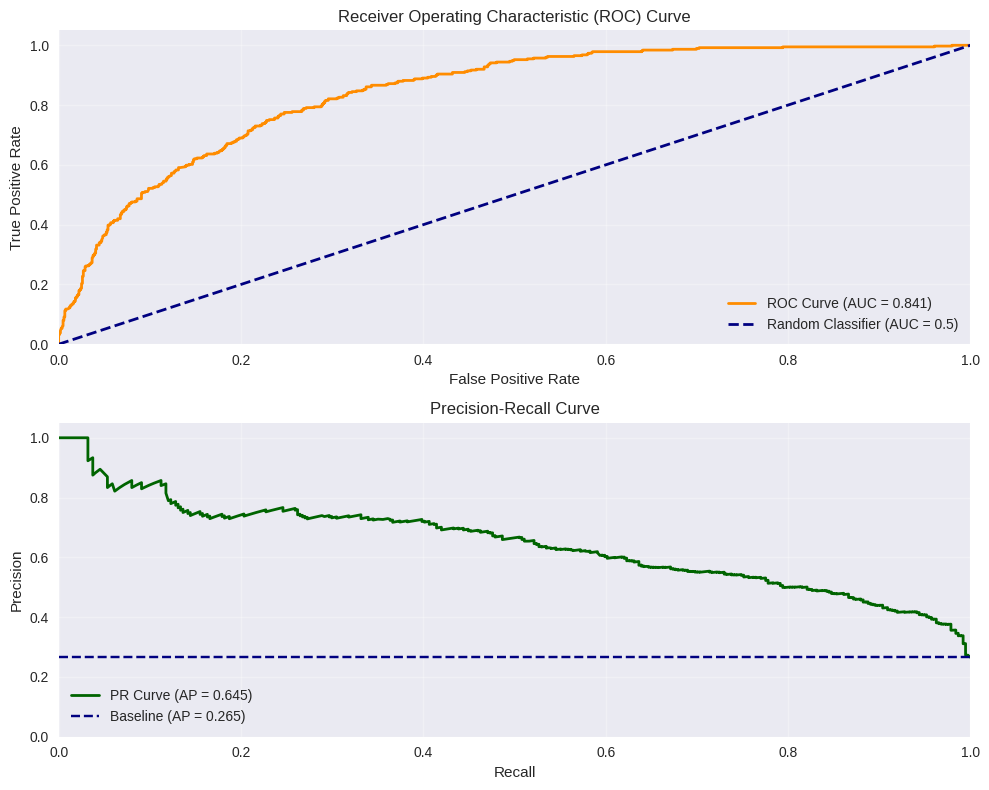

 ROC & PR Curve Analysis:
  • AUC-ROC: 0.841 - Good
  • Average Precision: 0.645
  • The model performs well at distinguishing churners from non-churners


In [45]:
if df is not None and target_col:
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, final_probabilities)

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC Curve (AUC = {final_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
             label='Random Classifier (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    # Precision-Recall curve for imbalanced datasets
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, final_probabilities)
    avg_precision = average_precision_score(y_test, final_probabilities)

    plt.subplot(2, 1, 2)
    plt.plot(recall_curve, precision_curve, color='darkgreen', lw=2,
             label=f'PR Curve (AP = {avg_precision:.3f})')
    plt.axhline(y=y_test.mean(), color='navy', linestyle='--',
                label=f'Baseline (AP = {y_test.mean():.3f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Interpretation
    print(" ROC & PR Curve Analysis:")
    print(f"  • AUC-ROC: {final_auc:.3f} - {'Excellent' if final_auc > 0.9 else 'Good' if final_auc > 0.8 else 'Fair' if final_auc > 0.7 else 'Poor'}")
    print(f"  • Average Precision: {avg_precision:.3f}")
    print(f"  • The model performs {'well' if final_auc > 0.75 else 'adequately'} at distinguishing churners from non-churners")

## 6.4 Feature Importance Analysis

 TOP 10 MOST IMPORTANT FEATURES FOR CHURN PREDICTION


,Feature,Importance
26,Contract_Two year,0.202076
4,tenure,0.147407
25,Contract_One year,0.127074
11,InternetService_Fiber optic,0.104584
28,PaymentMethod_Electronic check,0.089541
6,PaperlessBilling,0.048456
14,OnlineSecurity_Yes,0.034522
3,Dependents,0.030902
24,StreamingMovies_Yes,0.027886
20,TechSupport_Yes,0.025171


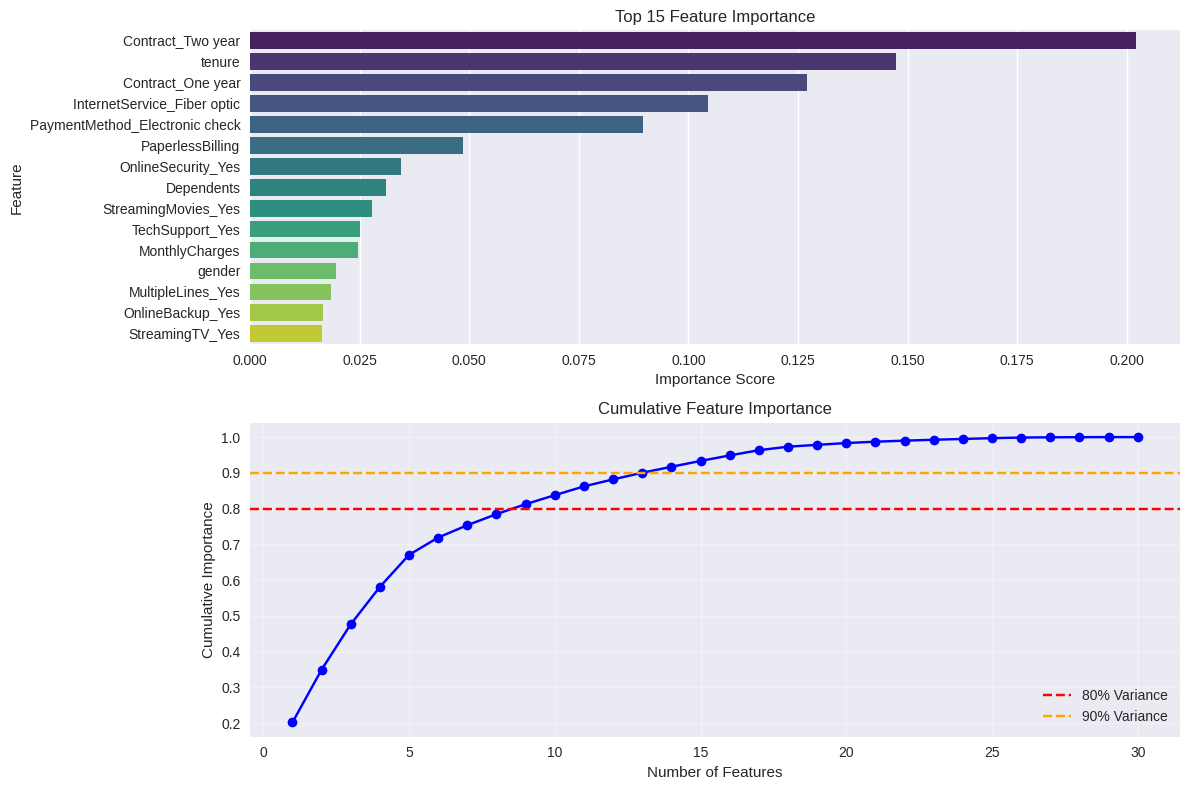


 Feature Analysis:
  • 9 features explain 80% of model importance
  • 13 features explain 90% of model importance
  • Total features used: 30

 KEY BUSINESS INSIGHTS:
Top factors contributing to customer churn:
  1. Contract_Two year: 0.2021 importance
  2. tenure: 0.1474 importance
  3. Contract_One year: 0.1271 importance
  4. InternetService_Fiber optic: 0.1046 importance
  5. PaymentMethod_Electronic check: 0.0895 importance


In [46]:
if df is not None and target_col:
    def get_feature_importance(model, feature_names):
        """
        Extract feature importance from different model types.
        """
        if hasattr(model, 'feature_importances_'):
            # Tree-based models
            return model.feature_importances_
        elif hasattr(model, 'coef_'):
            # Linear models
            return np.abs(model.coef_[0])
        else:
            return None

    # Get feature importance
    importance = get_feature_importance(final_model, X.columns)

    if importance is not None:
        # Create feature importance DataFrame
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importance
        }).sort_values('Importance', ascending=False)

        # Display top features
        print(" TOP 10 MOST IMPORTANT FEATURES FOR CHURN PREDICTION")
        print("=" * 60)
        display(feature_importance_df.head(10))

        # Visualize feature importance
        plt.figure(figsize=(12, 8))
        top_features = feature_importance_df.head(15)

        plt.subplot(2, 1, 1)
        sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
        plt.title('Top 15 Feature Importance')
        plt.xlabel('Importance Score')

        # Cumulative importance
        cumulative_importance = feature_importance_df['Importance'].cumsum() / feature_importance_df['Importance'].sum()

        plt.subplot(2, 1, 2)
        plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'bo-')
        plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance')
        plt.axhline(y=0.9, color='orange', linestyle='--', label='90% Variance')
        plt.xlabel('Number of Features')
        plt.ylabel('Cumulative Importance')
        plt.title('Cumulative Feature Importance')
        plt.legend()
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Find number of features for 80% importance
        features_80 = (cumulative_importance >= 0.8).argmax() + 1
        features_90 = (cumulative_importance >= 0.9).argmax() + 1

        print(f"\n Feature Analysis:")
        print(f"  • {features_80} features explain 80% of model importance")
        print(f"  • {features_90} features explain 90% of model importance")
        print(f"  • Total features used: {len(X.columns)}")

        # Business insights from top features
        print("\n KEY BUSINESS INSIGHTS:")
        print("Top factors contributing to customer churn:")
        for i, (_, row) in enumerate(feature_importance_df.head(5).iterrows(), 1):
            print(f"  {i}. {row['Feature']}: {row['Importance']:.4f} importance")
    else:
        print(" Feature importance not available for this model type")

## 6.5 Business Recommendations & Action Plan

In [47]:
if df is not None and target_col:
    print(" BUSINESS RECOMMENDATIONS & ACTION PLAN")
    print("=" * 50)

    # Model deployment recommendations
    print("\n MODEL DEPLOYMENT:")
    print(f"  • Model Readiness: {'Ready for production' if final_f1 > 0.7 else 'Needs improvement'}")
    print(f"  • Expected Performance: {final_f1*100:.1f}% F1-score on new data")
    print(f"  • Recommended Threshold: 0.5 (adjustable based on business priorities)")

    # Customer segmentation based on churn risk
    churn_probabilities = final_probabilities
    high_risk = (churn_probabilities > 0.7).sum()
    medium_risk = ((churn_probabilities > 0.3) & (churn_probabilities <= 0.7)).sum()
    low_risk = (churn_probabilities <= 0.3).sum()

    print("\n CUSTOMER RISK SEGMENTATION:")
    print(f"  • High Risk (>70% churn probability): {high_risk} customers")
    print(f"  • Medium Risk (30-70% churn probability): {medium_risk} customers")
    print(f"  • Low Risk (<30% churn probability): {low_risk} customers")

    # Action recommendations by risk level
    print("\n RECOMMENDED ACTIONS BY RISK LEVEL:")
    print("\n  HIGH RISK CUSTOMERS:")
    print("    - Immediate outreach by customer success team")
    print("    - Personalized retention offers or discounts")
    print("    - Priority customer support")
    print("    - Executive-level intervention if high-value customers")

    print("\n  MEDIUM RISK CUSTOMERS:")
    print("    - Proactive engagement campaigns")
    print("    - Product feature education")
    print("    - Satisfaction surveys and feedback collection")
    print("    - Loyalty program enrollment")

    print("\n  LOW RISK CUSTOMERS:")
    print("    - Standard communication cadence")
    print("    - Upselling and cross-selling opportunities")
    print("    - Referral program participation")
    print("    - Case study and testimonial opportunities")

    # ROI estimation
    print("\n ESTIMATED BUSINESS IMPACT:")
    tp_rate = final_recall
    print(f"  • Churn Detection Rate: {tp_rate*100:.1f}%")
    print(f"  • If avg customer value is 1000Rs and 50% retention success:")
    print(f"    - Potential value saved per month: {int(tp * 1000 * 0.5):,} Rs")
    print(f"    - Annual potential impact: {int(tp * 1000 * 0.5 * 12):,} Rs")

    # Model monitoring recommendations
    print("\n MODEL MONITORING & MAINTENANCE:")
    print("  • Retrain model monthly with new data")
    print("  • Monitor model performance metrics weekly")
    print("  • Track prediction accuracy vs actual churn")
    print("  • Alert if model performance drops below 70% F1-score")
    print("  • A/B test different thresholds for optimal business outcomes")

    # Next steps
    print("\n NEXT STEPS:")
    print("  1. Validate model performance with business stakeholders")
    print("  2. Implement model in production environment")
    print("  3. Set up automated scoring pipeline")
    print("  4. Create dashboard for monitoring churn predictions")
    print("  5. Train customer success team on using predictions")
    print("  6. Establish feedback loop for model improvement")

 BUSINESS RECOMMENDATIONS & ACTION PLAN

 MODEL DEPLOYMENT:
  • Model Readiness: Needs improvement
  • Expected Performance: 61.5% F1-score on new data
  • Recommended Threshold: 0.5 (adjustable based on business priorities)

 CUSTOMER RISK SEGMENTATION:
  • High Risk (>70% churn probability): 247 customers
  • Medium Risk (30-70% churn probability): 413 customers
  • Low Risk (<30% churn probability): 749 customers

 RECOMMENDED ACTIONS BY RISK LEVEL:

  HIGH RISK CUSTOMERS:
    - Immediate outreach by customer success team
    - Personalized retention offers or discounts
    - Priority customer support
    - Executive-level intervention if high-value customers

  MEDIUM RISK CUSTOMERS:
    - Proactive engagement campaigns
    - Product feature education
    - Satisfaction surveys and feedback collection
    - Loyalty program enrollment

  LOW RISK CUSTOMERS:
    - Standard communication cadence
    - Upselling and cross-selling opportunities
    - Referral program participation
    -

**6.6 Save Model and Results**

In [48]:
import os
if df is not None and target_col:


  # Ensure directories exist
    os.makedirs("../models", exist_ok=True)
    os.makedirs("../results", exist_ok=True)


    # Save the trained model
    model_filename = '../models/churn_prediction_model.pkl'
    scaler_filename = '../models/feature_scaler.pkl'

    try:
        # Save model
        joblib.dump(final_model, model_filename)
        print(f" Model saved to {model_filename}")

        # Save scaler
        joblib.dump(scaler, scaler_filename)
        print(f" Feature scaler saved to {scaler_filename}")

        # Save feature names for future use
        feature_names_file = '../models/feature_names.pkl'
        joblib.dump(list(X.columns), feature_names_file)
        print(f" Feature names saved to {feature_names_file}")

        # Save results summary
        results_summary = {
            'model_name': best_model_name,
            'accuracy': final_accuracy,
            'precision': final_precision,
            'recall': final_recall,
            'f1_score': final_f1,
            'auc': final_auc,
            'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'training_samples': len(X_train_final),
            'test_samples': len(X_test),
            'features_count': len(X.columns)
        }

        results_file = '../results/model_performance_summary.pkl'
        joblib.dump(results_summary, results_file)
        print(f" Results summary saved to {results_file}")

        # Create predictions CSV for business use
        predictions_df = pd.DataFrame({
            'actual_churn': y_test.values,
            'predicted_churn': final_predictions,
            'churn_probability': final_probabilities,
            'risk_level': pd.cut(final_probabilities,
                               bins=[0, 0.3, 0.7, 1.0],
                               labels=['Low', 'Medium', 'High'])
        }, index=y_test.index)

        predictions_file = '../results/churn_predictions.csv'
        predictions_df.to_csv(predictions_file)
        print(f" Test predictions saved to {predictions_file}")

        if importance is not None:
            feature_importance_file = '../results/feature_importance.csv'
            feature_importance_df.to_csv(feature_importance_file, index=False)
            print(f" Feature importance saved to {feature_importance_file}")

        print("\n All files saved successfully!")
        print("\n Saved files:")
        print(f"  • Model: {model_filename}")
        print(f"  • Scaler: {scaler_filename}")
        print(f"  • Features: {feature_names_file}")
        print(f"  • Results: {results_file}")
        print(f"  • Predictions: {predictions_file}")
        if importance is not None:
            print(f"  • Feature Importance: {feature_importance_file}")

    except Exception as e:
        print(f" Error saving files: {str(e)}")
        print("Please check that the models and results directories exist and are writable.")

    print("\n" + "=" * 60)
    print(" CUSTOMER CHURN PREDICTION PIPELINE COMPLETED!")
    print("=" * 60)
    print(f"Final Model: {best_model_name}")
    print(f"Performance: F1-Score = {final_f1:.3f}, AUC = {final_auc:.3f}")
    print("Ready for deployment and business integration!")
else:
    print("\n To run this complete pipeline:")
    print("1. Place your customer_data.csv in the data/ directory")
    print("2. Ensure the CSV has a 'Churn' column (Yes/No or 1/0)")
    print("3. Run all cells from the beginning")
    print("\nThe pipeline will automatically:")
    print("• Load and clean your data")
    print("• Perform comprehensive EDA")
    print("• Train multiple ML models")
    print("• Select and tune the best model")
    print("• Generate business insights and recommendations")
    print("• Save the final model for deployment")

 Model saved to ../models/churn_prediction_model.pkl
 Feature scaler saved to ../models/feature_scaler.pkl
 Feature names saved to ../models/feature_names.pkl
 Results summary saved to ../results/model_performance_summary.pkl
 Test predictions saved to ../results/churn_predictions.csv
 Feature importance saved to ../results/feature_importance.csv

 All files saved successfully!

 Saved files:
  • Model: ../models/churn_prediction_model.pkl
  • Scaler: ../models/feature_scaler.pkl
  • Features: ../models/feature_names.pkl
  • Results: ../results/model_performance_summary.pkl
  • Predictions: ../results/churn_predictions.csv
  • Feature Importance: ../results/feature_importance.csv

 CUSTOMER CHURN PREDICTION PIPELINE COMPLETED!
Final Model: Gradient Boosting
Performance: F1-Score = 0.615, AUC = 0.841
Ready for deployment and business integration!
